<a href="https://colab.research.google.com/github/taliarosenkranz/Marketing_Analysis_Forecasting/blob/main/analysis_h3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal of Analysis: How did past campaigns perform and what were the features that had major influences on the success of the campaigns. Can these features also forcast the likelyhood of success per customer, for a current campaign?
We will be looking at the distribution of the data, how the features correlate with our target variable and train a binary classification machine learning model for predicting a campaigns success or failure for a given customer.

There seem to be a lot of null values in the poutcome column. this is because there is currently a campaign running and in which these customers are involved in. the pday feature shows -1 for all of the clients that have nan as poutcome, as they are new clients and have not been contacted before. When analyzing the performance of previous campaigns, we are excluding new clients.

In [3]:
!pip install ucimlrepo

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [6]:
df = X.merge(y, how='inner', left_index=True, right_index=True)

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [8]:
df.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

In [9]:
df[df["job"].isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no
216,47,NaN,married,NaN,no,28,no,no,NaN,5,may,338,2,-1,0,NaN,no
354,59,NaN,divorced,NaN,no,27,no,no,NaN,5,may,347,3,-1,0,NaN,no
876,37,NaN,single,NaN,no,414,yes,no,NaN,7,may,131,1,-1,0,NaN,no
1072,29,NaN,single,primary,no,50,yes,no,NaN,7,may,50,2,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44714,45,NaN,married,tertiary,no,406,no,no,cellular,7,sep,314,1,-1,0,NaN,yes
44742,64,NaN,married,NaN,no,2799,no,no,telephone,9,sep,378,4,-1,0,NaN,no
44970,28,NaN,single,NaN,no,326,no,no,cellular,11,oct,450,1,231,1,success,yes
45141,77,NaN,married,NaN,no,397,no,no,telephone,8,nov,207,1,185,3,success,no


In [10]:
df[df["duration"]==0]

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
6424,53,management,married,primary,no,351,yes,no,NaN,27,may,0,4,-1,0,NaN,no
22937,35,technician,married,secondary,no,5535,no,no,cellular,26,aug,0,15,-1,0,NaN,no
36425,31,entrepreneur,married,secondary,no,162,yes,yes,cellular,11,may,0,2,-1,0,NaN,no


In [11]:
df[df["duration"]==2]

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
287,50,technician,single,tertiary,no,339,yes,no,NaN,5,may,2,3,-1,0,NaN,no
24994,36,blue-collar,married,primary,no,871,yes,yes,telephone,18,nov,2,1,-1,0,NaN,no
30278,54,unemployed,divorced,secondary,no,925,no,no,cellular,5,feb,2,1,-1,0,NaN,no


In [12]:
#replacing missing values
df['job'].fillna('unknown', inplace=True)
df['education'].fillna('unknown', inplace=True)
df['contact'].fillna('unknown', inplace=True)
df['poutcome'].fillna('ongoing', inplace=True)

In [13]:
#Number of successful campaigns
success_count = df[df["poutcome"] == "success"].shape[0]

#Total count excluding "unknown" values in "poutcome" column
total_count = df[df["poutcome"] != "unknown"].shape[0]

#Calculating conversion rate
cr = (success_count / total_count) * 100
print(f"{round(cr, 2)}% of clients are considered a success for the marketing campaign.")

3.34% of clients are considered a success for the marketing campaign.


In [14]:
#group by campaign (number of times that client was called) and calculate the success rate. this way we can see if it makes sense to call more or less for higher chances of success.
df_campaign = df[(df["poutcome"] != "other") & (df["poutcome"] != "ongoing")]
df_campaign_ = df_campaign.groupby(['campaign', 'poutcome'])['poutcome'].count().reset_index(name="outcome_count")

# Calculate the mean duration for each campaign and poutcome combination
mean_duration = df_campaign.groupby(['campaign', 'poutcome'])['duration'].mean().reset_index(name='duration_mean')

# Merge the mean duration DataFrame with the df_campaign DataFrame
df_campaign = pd.merge(df_campaign_, mean_duration, on=['campaign', 'poutcome'])

# Print the updated DataFrame
df_campaign

,campaign,poutcome,outcome_count,duration_mean
0,1,failure,2458,242.982506
1,1,success,837,311.731183
2,2,failure,1374,254.155022
3,2,success,402,329.808458
4,3,failure,500,271.308000
5,3,success,149,355.503356
6,4,failure,242,220.495868
7,4,success,51,278.627451
8,5,failure,140,209.264286
9,5,success,30,280.500000


In [15]:
# Calculate conversion rate for each row
df_campaign['conversion_rate'] = df_campaign.apply(lambda row: row['outcome_count'] / df_campaign[df_campaign['campaign'] == row['campaign']]['outcome_count'].sum(), axis=1)

# Print the updated DataFrame
df_campaign

,campaign,poutcome,outcome_count,duration_mean,conversion_rate
0,1,failure,2458,242.982506,0.745979
1,1,success,837,311.731183,0.254021
2,2,failure,1374,254.155022,0.773649
3,2,success,402,329.808458,0.226351
4,3,failure,500,271.308000,0.770416
5,3,success,149,355.503356,0.229584
6,4,failure,242,220.495868,0.825939
7,4,success,51,278.627451,0.174061
8,5,failure,140,209.264286,0.823529
9,5,success,30,280.500000,0.176471


<BarContainer object of 25 artists>

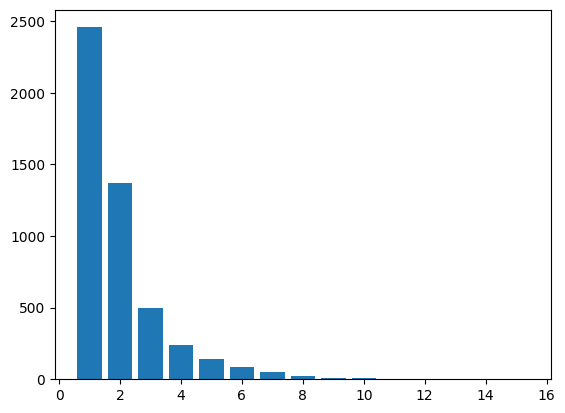

In [16]:
plt.bar(df_campaign.campaign, df_campaign.outcome_count)

<Axes: xlabel='poutcome', ylabel='count'>

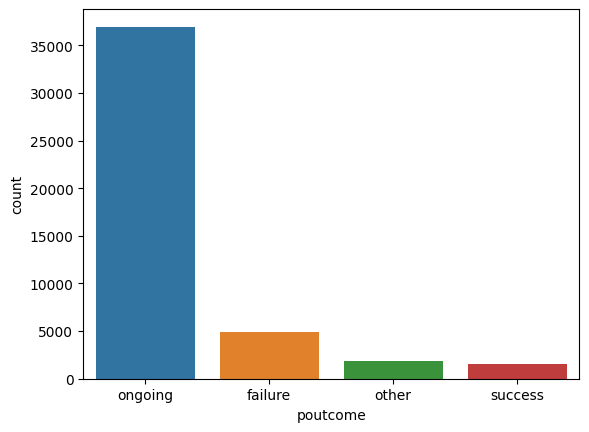

In [17]:
sns.countplot(x=df.poutcome, data=df, hue = df.poutcome)

The following graphs show the percentage of success and failure individual values from various features had in past marketing campaigns (poutcome). Important to keep in mind that correlation is not causation (ex: just because we see a high number of people that have never taken a loan, and were not successfully converted in the marketing campaign, does not mean that the cause for lack of success was the lack of a loan).

In [18]:
%matplotlib inline
def countplot_withY(label, dataset):
  dataset = dataset[(dataset["poutcome"] != "other") & (dataset["poutcome"] != "ongoing")]
  plt.figure(figsize=(20,10))
  Y = dataset[label]
  total = len(Y)*1.
  ax=sns.countplot(x=label, data=dataset, hue="poutcome")
  for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

  #put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
  ax.yaxis.set_ticks(np.linspace(0, total, 11))
  #adjust the ticklabel to the desired format, without changing the position of the ticks.
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.title(f'{label} ')
  plt.show()

<ipython-input-18-4ac873a6ed85>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


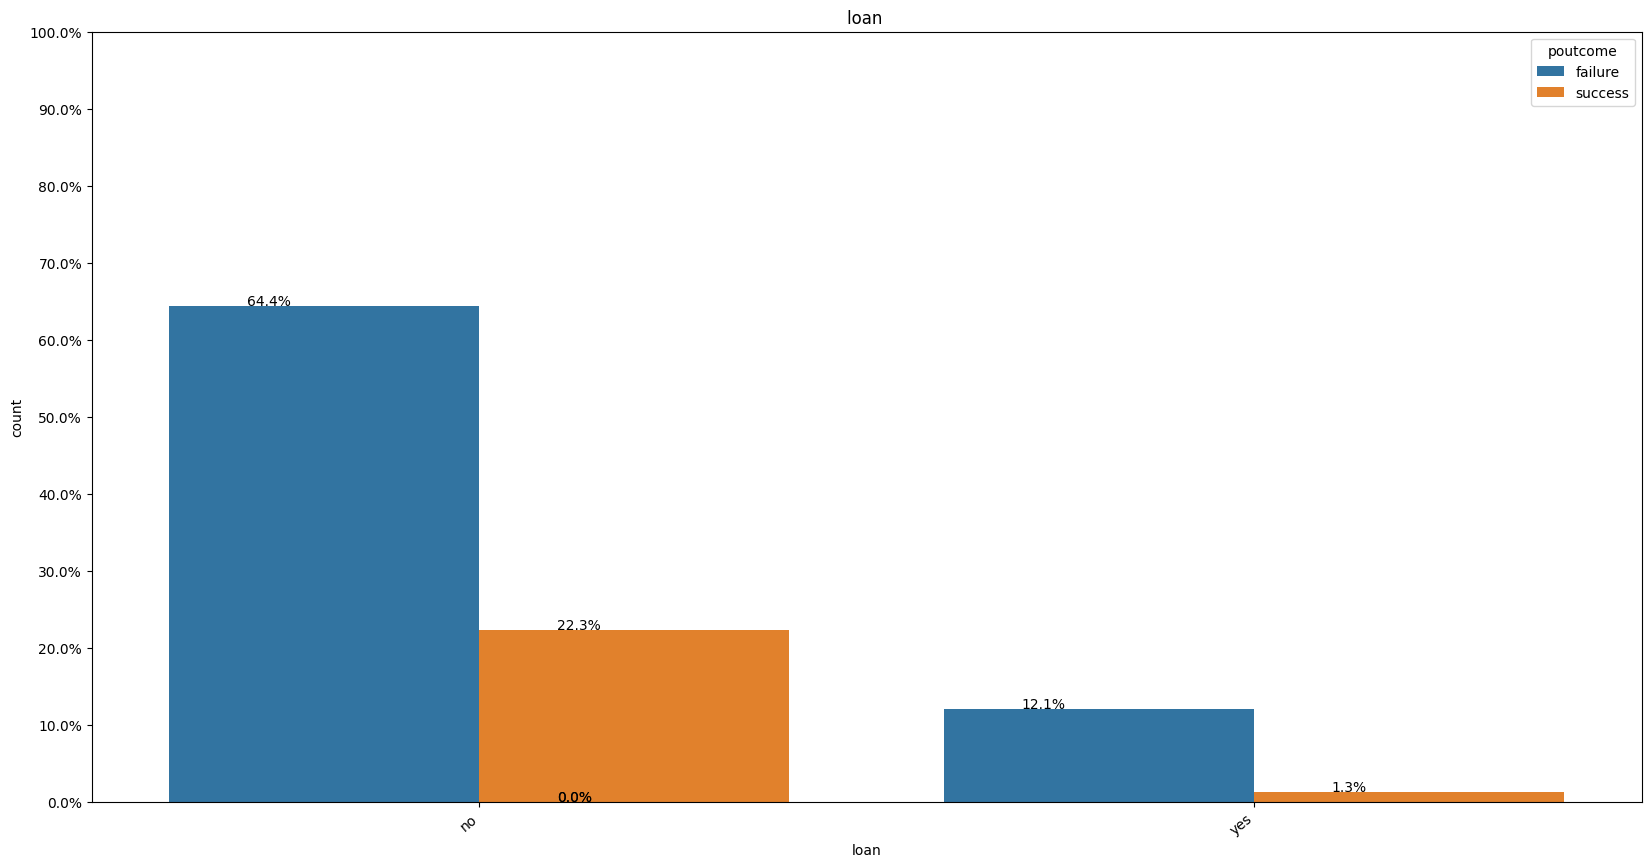

In [19]:
countplot_withY('loan', df)

Those that have not had a loan in the past show a high percentage (64%) of failure to achieve historical marketing campaigns while only 1.3% of customers that have had a loan in the past werde successfully converted.

<ipython-input-18-4ac873a6ed85>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


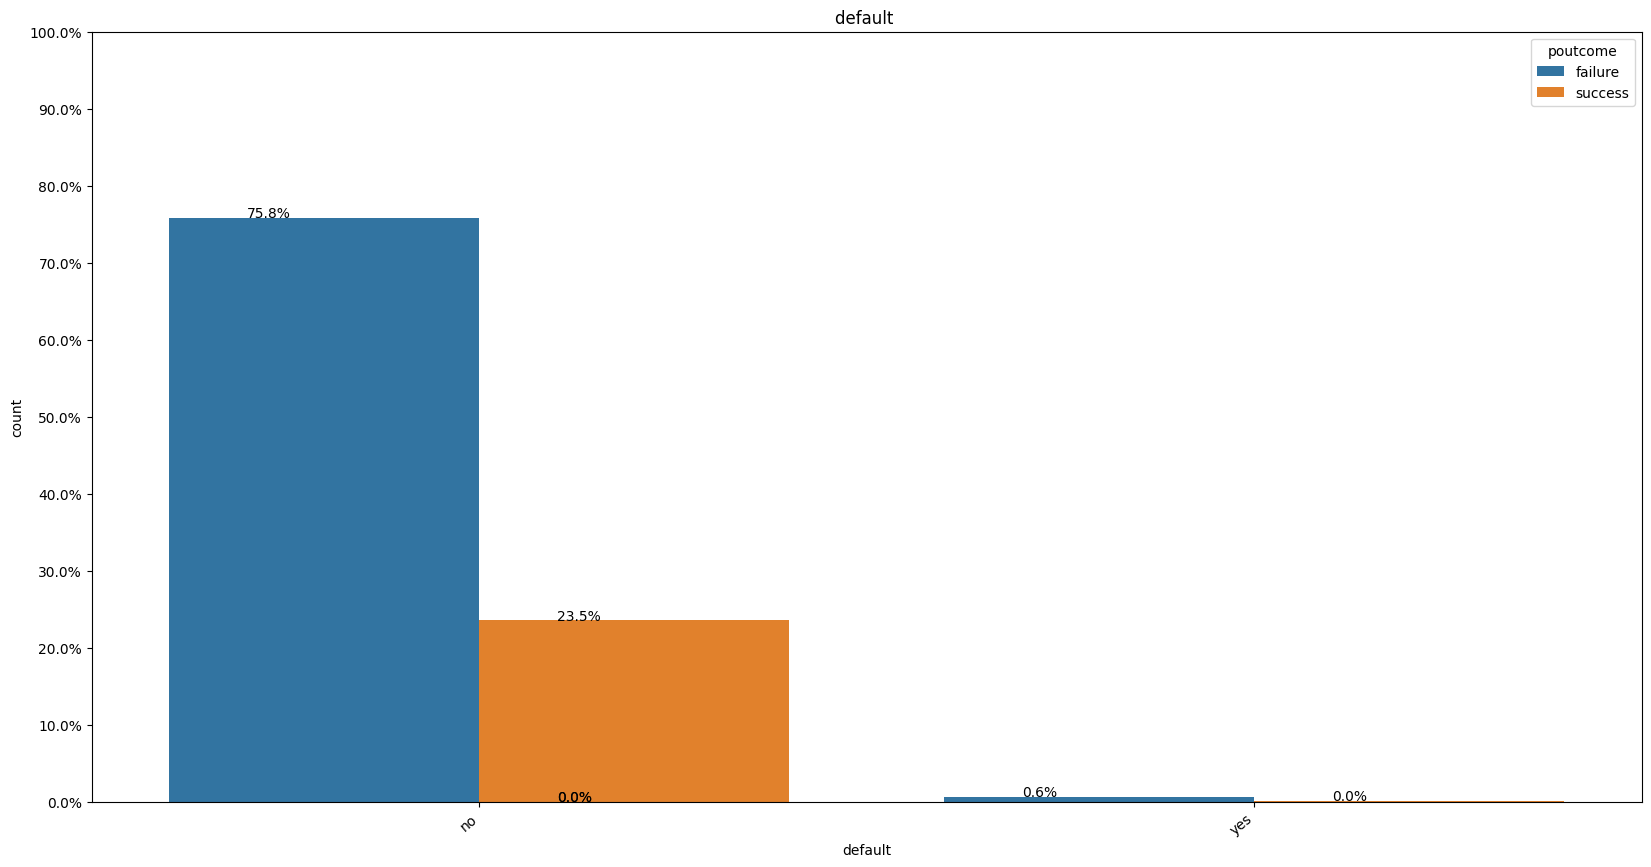

In [20]:
countplot_withY('default', df)

<ipython-input-18-4ac873a6ed85>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


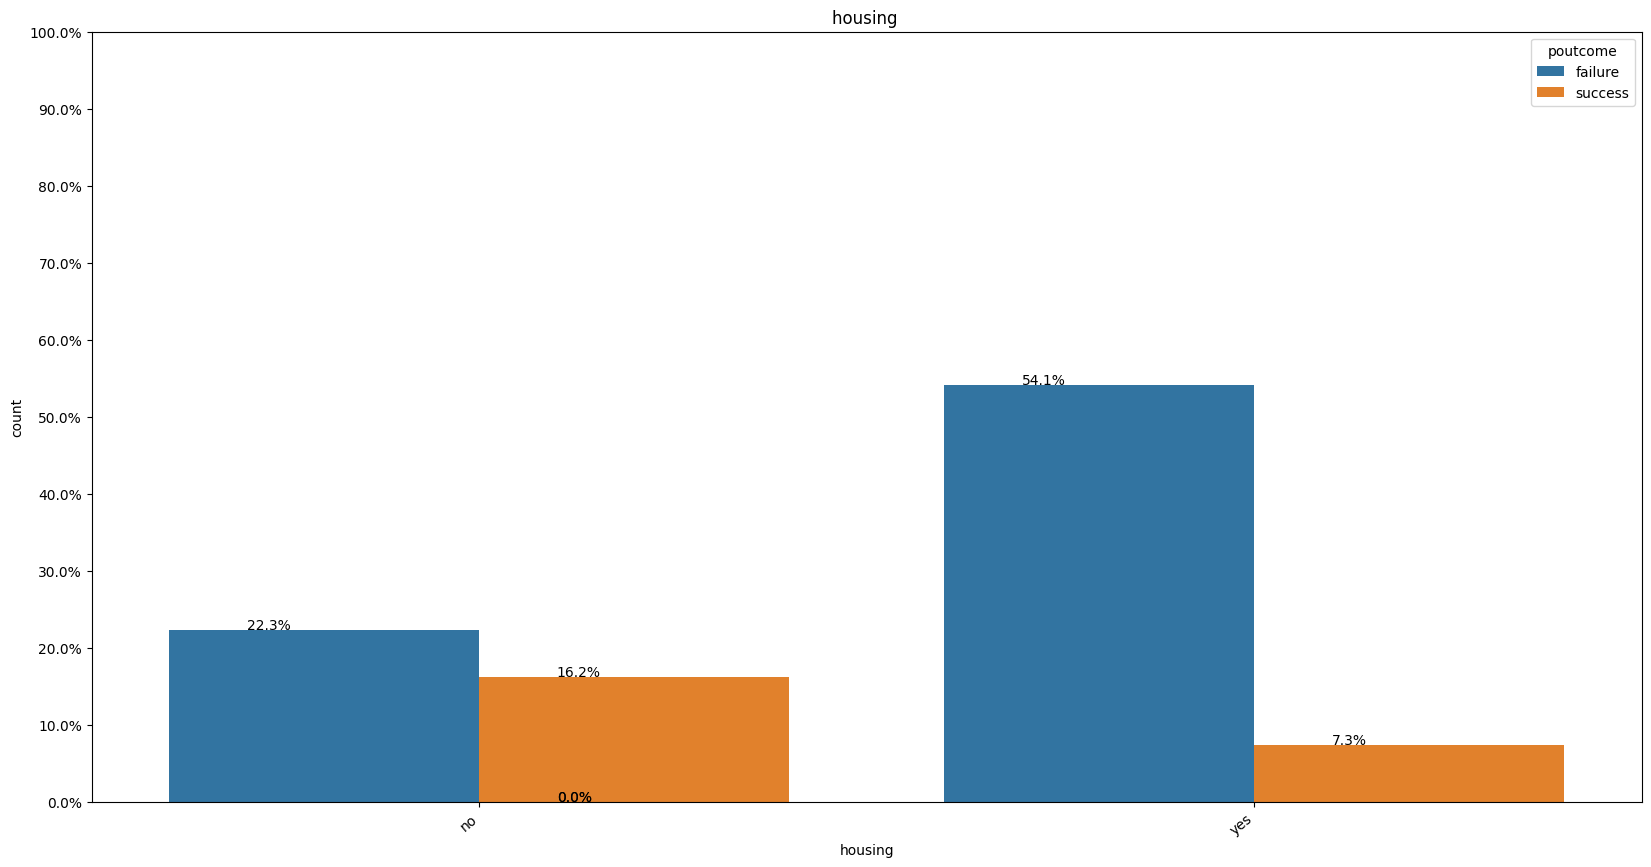

In [21]:
countplot_withY('housing', df)

<ipython-input-18-4ac873a6ed85>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


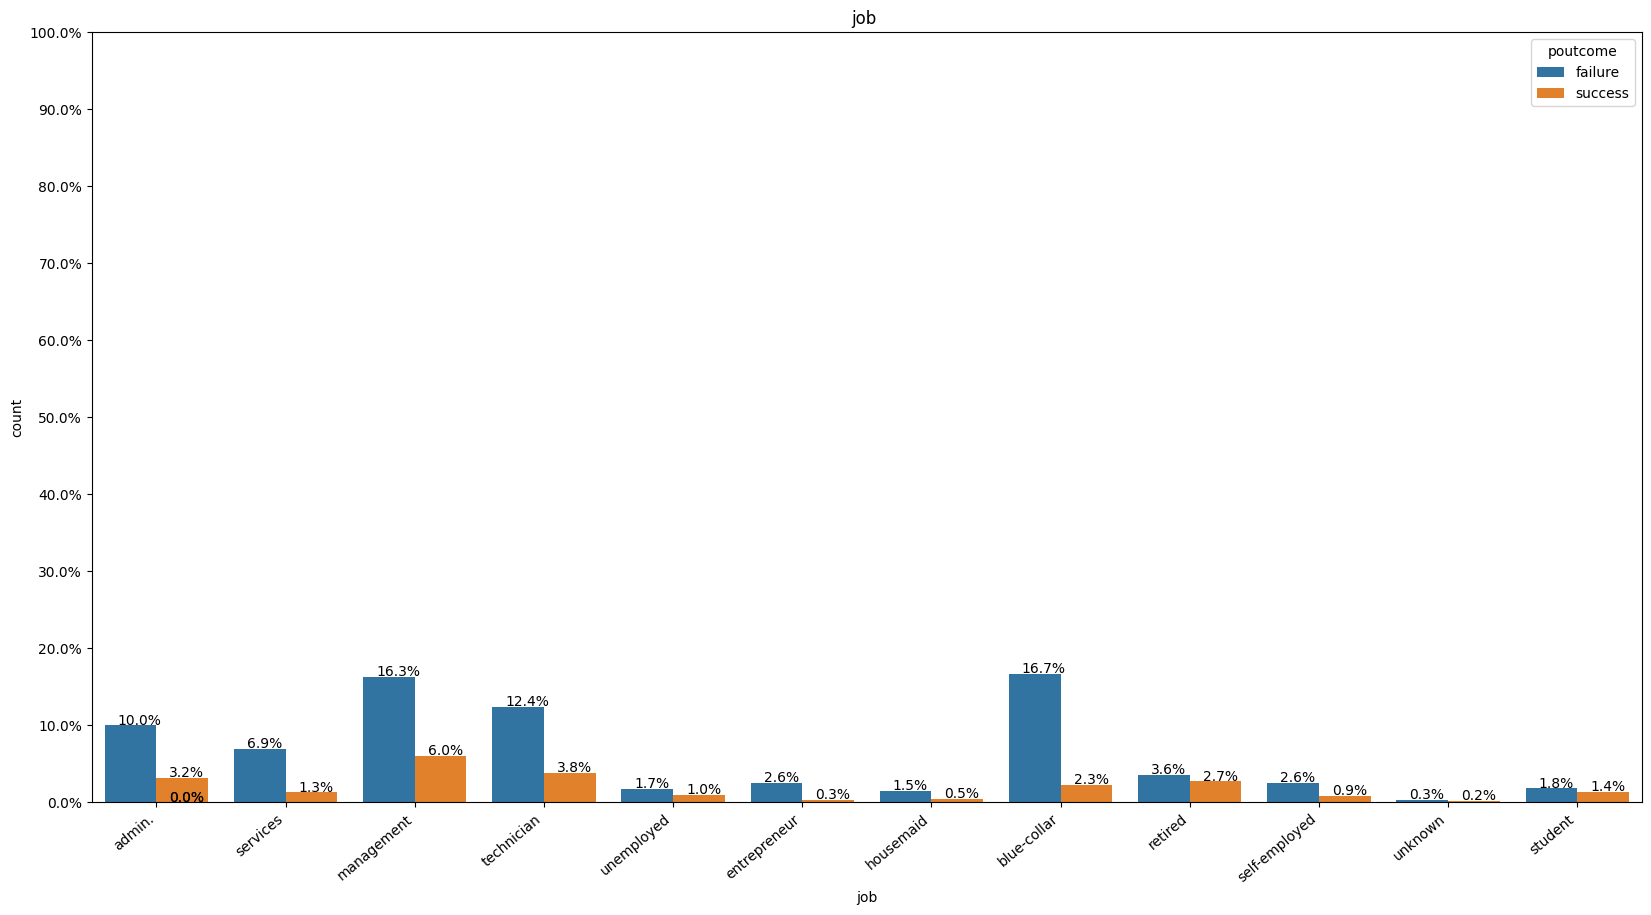

In [22]:
countplot_withY("job", df)

Most successful past marketing campaigns were by customers working in management, as technicians, retired and blue-collar. However, these also had the highest rate of failure therefore not necessarily a good choice for investing into targeting these customers. Unemplyed, students and retired seem to have equal chances  in success and failure. There is not a singel job in which there were more successes than failres.

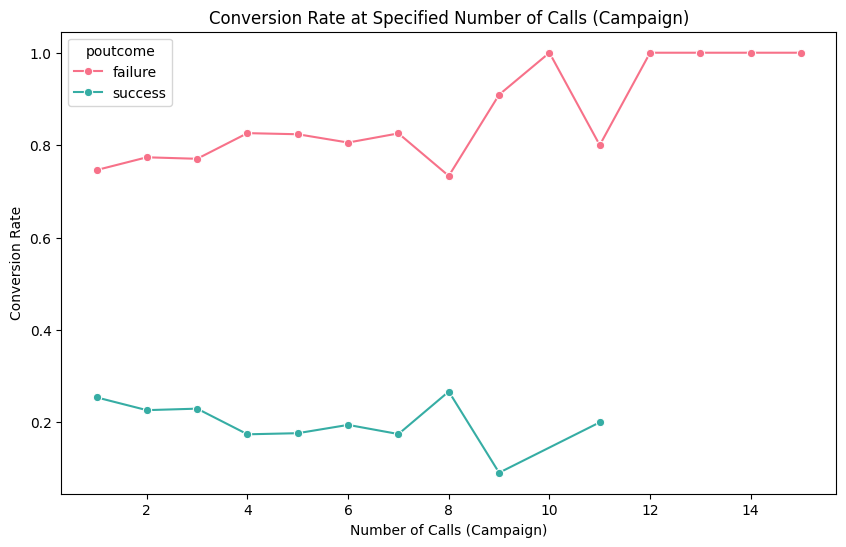

In [23]:


# Plot conversion rate against campaign
plt.figure(figsize=(10, 6))
sns.lineplot(x='campaign', y='conversion_rate', hue='poutcome', data=df_campaign, marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Conversion Rate at Specified Number of Calls (Campaign)')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Conversion Rate')

# Show the plot
plt.show()


At no point are the successes higher than the failure, however we do see that the highest success rate is at 8 calls. after that, the opportunity cost will not be worth it anymore as the chaces for failure are too high. Actually we see that from 11 calls onwards there are no successes at all anymore.

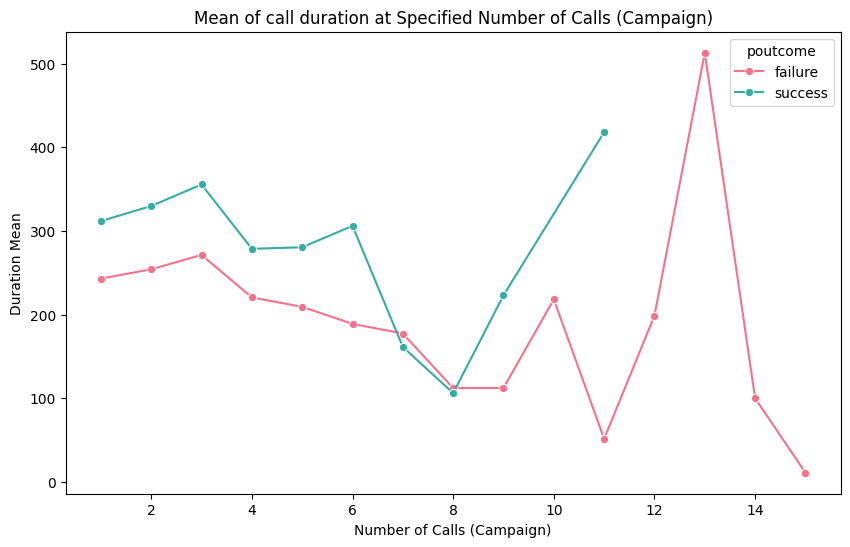

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='campaign', y='duration_mean', hue='poutcome', data=df_campaign, marker='o', palette='husl')

# Set title, x-label, and y-label
plt.title('Mean of call duration at Specified Number of Calls (Campaign)')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Duration Mean')

# Show the plot
plt.show()

Plotting the mean of each call duration by campaign (number of calls per person), we can infer that the chances for success are higher when the call is longer, within the first 6 calls. As we saw in the previous plot, a total of 8 calls has the highest conversion rate for success, however with short durations of that call. One reason for that could be that the deal is being closed in that call, and no more time is taken up by sales technique and convincing of the customer. Additionally, we can see that the mean duration strongly increases for any calls after the 8th. However from the 9th call on, these can be considered outliers, as the number of clients that have received this high number of calls are within the single digits.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


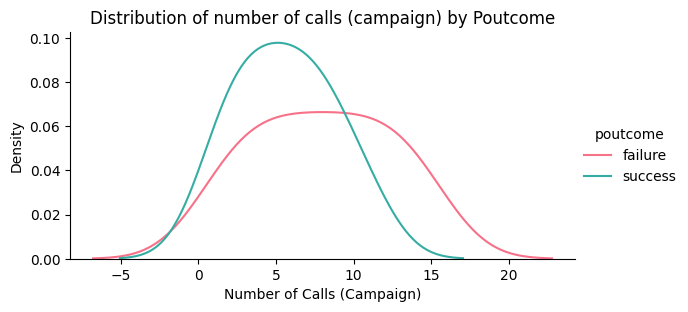

In [25]:
# Create a FacetGrid plot
g = sns.FacetGrid(df_campaign, hue="poutcome", palette="husl", aspect=2)

# Map the distribution plot to the 'campaign' column
g.map(sns.distplot, 'campaign', hist=False)

# Add legend
g.add_legend()

# Set title, x-label, and y-label
plt.title('Distribution of number of calls (campaign) by Poutcome')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Density')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


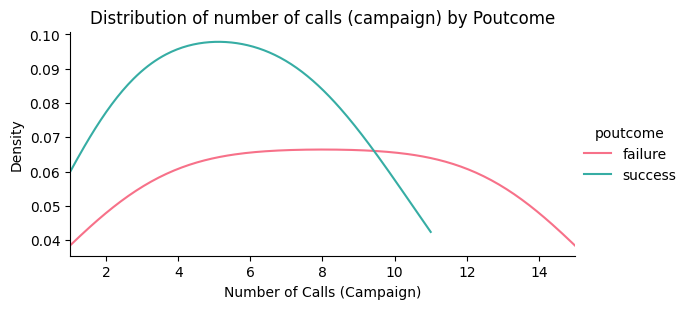

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_campaign is your DataFrame containing the filtered data
# df_campaign = ...

# Create a FacetGrid plot
g = sns.FacetGrid(df_campaign, hue="poutcome", palette="husl", aspect=2)

# Map the distribution plot to the 'campaign' column
g.map(sns.distplot, 'campaign', hist=False, kde_kws={'cut': 0})

# Add legend
g.add_legend()

# Set title, x-label, and y-label
plt.title('Distribution of number of calls (campaign) by Poutcome')
plt.xlabel('Number of Calls (Campaign)')
plt.ylabel('Density')

# Set x-axis limits manually
plt.xlim(df_campaign['campaign'].min(), df_campaign['campaign'].max())

# Show the plot
plt.show()

# Encoding categorical columns

In [27]:
cat_cols= df.select_dtypes(include =[object])

In [28]:
cat_cols

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,ongoing,no
1,technician,single,secondary,no,yes,no,unknown,may,ongoing,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,ongoing,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,ongoing,no
4,unknown,single,unknown,no,no,no,unknown,may,ongoing,no
...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,nov,ongoing,yes
45207,retired,divorced,primary,no,no,no,cellular,nov,ongoing,yes
45208,retired,married,secondary,no,no,no,cellular,nov,success,yes
45209,blue-collar,married,secondary,no,no,no,telephone,nov,ongoing,no


In [29]:
encoded_df = pd.get_dummies(df)

In [30]:
encoded_df

,age,balance,day_of_week,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_ongoing,poutcome_other,poutcome_success,y_no,y_yes
0,58,2143,5,261,1,-1,0,False,False,False,...,True,False,False,False,False,True,False,False,True,False
1,44,29,5,151,1,-1,0,False,False,False,...,True,False,False,False,False,True,False,False,True,False
2,33,2,5,76,1,-1,0,False,False,True,...,True,False,False,False,False,True,False,False,True,False
3,47,1506,5,92,1,-1,0,False,True,False,...,True,False,False,False,False,True,False,False,True,False
4,33,1,5,198,1,-1,0,False,False,False,...,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,False,False,False,...,False,True,False,False,False,True,False,False,False,True
45207,71,1729,17,456,2,-1,0,False,False,False,...,False,True,False,False,False,True,False,False,False,True
45208,72,5715,17,1127,5,184,3,False,False,False,...,False,True,False,False,False,False,False,True,False,True
45209,57,668,17,508,4,-1,0,False,True,False,...,False,True,False,False,False,True,False,False,True,False


In [31]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming X is your feature matrix and y is your target variable
X = encoded_df.drop(["y_no","y_yes", "duration"], axis = 1)[:]
y = df['y']
print(X.shape)
print(y.shape)
# Initialize Random Forest classifier
rf = RandomForestClassifier()

#splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Fitting data and model
rf.fit(X_train, y_train)
# forecasting with model
pred = rf.predict(X_test)
#preducting probability of forecast outcome
pred_probability = rf.predict_proba(X_test)




(45211, 50)
(45211,)


Evaluation of Random Forrest Classifier

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, pred)
print('CONFUSION MATRIX')
print(cm)

accuracy_score = accuracy_score(y_test, pred)
print('ACCURACY SCORE: ',accuracy_score)

classification_report = classification_report(y_test, pred)
print('CLASSIFICATION REPORT')
print(classification_report)

CONFUSION MATRIX
[[7814  138]
 [ 828  263]]
ACCURACY SCORE:  0.893177043016698
CLASSIFICATION REPORT
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      7952
         yes       0.66      0.24      0.35      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.61      0.65      9043
weighted avg       0.87      0.89      0.87      9043



Feature importance:

In [33]:
df["y"].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

Random forrest seems to have performed quite well. However the target variable distrubution is strongly unbalanced. There are a lot more 'no' for marketing We will attempt to even out the data in attempt to increase the models performance and limit bias

In [34]:
# Calculate class weights
total_samples = df["y"].value_counts().sum()
weight_no = 1 / (4816 / total_samples)
weight_yes = 1 / (2.5 * (1596 / total_samples))

# Define class weights dictionary
class_weights = {'no': weight_no, 'yes': weight_yes}

# Initialize Random Forest classifier with class weights
rf_weighted = RandomForestClassifier(class_weight=class_weights)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Fit the classifier to your training data
rf_weighted.fit(X_train, y_train)
# forecasting with model
pred = rf_weighted.predict(X_test)
#preducting probability of forecast outcome
pred_probability = rf_weighted.predict_proba(X_test)

#EVALUATION OF MODEL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, pred)
print('CONFUSION MATRIX')
print(cm)

accuracy = accuracy_score(y_test, pred)
print('ACCURACY SCORE: ',accuracy)

class_report = classification_report(y_test, pred)
print('CLASSIFICATION REPORT')
print(class_report)

CONFUSION MATRIX
[[7815  137]
 [ 825  266]]
ACCURACY SCORE:  0.8936193741015149
CLASSIFICATION REPORT
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      7952
         yes       0.66      0.24      0.36      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.61      0.65      9043
weighted avg       0.88      0.89      0.87      9043



Adding weights to the model slightly increased the precision of for the prediction of the 'yes' target which was originally undersampled. The confusion matrix shows no significant improvement.

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Separate majority and minority classes
df_majority = df[df['y'] == 'no']
df_minority = df[df['y'] == 'yes']

# Sample the majority class to match the size of the minority class
df_majority_sampled = df_majority.sample(n=len(df_minority), random_state=42)

# Concatenate the sampled majority class with the minority class
df_balanced = pd.concat([df_majority_sampled, df_minority])

# Shuffle the dataframe to mix the samples
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize Random Forest classifier with class weights
rf_balanced = RandomForestClassifier(class_weight='balanced')

X = encoded_df.drop(["y_no","y_yes", "duration"], axis = 1)[:]
y = df['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Fit the classifier to your training data
rf_balanced.fit(X_train, y_train)

# Forecasting with the model
y_pred = rf_balanced.predict(X_test)

# Predicting probability of forecast outcome
y_pred_proba = rf_balanced.predict_proba(X_test)

# Evaluation of model
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print('ACCURACY SCORE:', accuracy)

classification_report_str = classification_report(y_test, y_pred)
print('CLASSIFICATION REPORT')
print(classification_report_str)


CONFUSION MATRIX
[[7831  121]
 [ 850  241]]
ACCURACY SCORE: 0.8926241291606768
CLASSIFICATION REPORT
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      7952
         yes       0.67      0.22      0.33      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.60      0.64      9043
weighted avg       0.87      0.89      0.87      9043



Text(0.5, 1.0, 'Confusion Matrix')

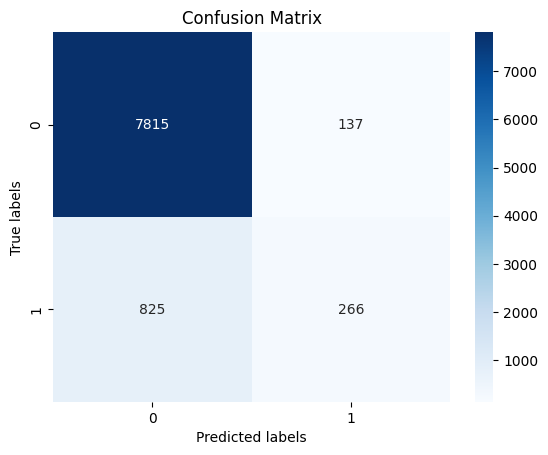

In [36]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot

    True Positives (TP) = 146
    True Negatives (TN) = 903
    False Positives (FP) = 85
    False Negatives (FN) = 149
    
    We now undersampled the unbalanced target variable in an attempt to gain better model performance.
    This did lead to less false positves however we still cannot see a significant imrovement.

In [37]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to hold feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                Feature  Importance
1               balance    0.171095
0                   age    0.148443
2           day_of_week    0.123234
3              campaign    0.062309
49     poutcome_success    0.051307
4                 pdays    0.046741
5              previous    0.025136
22  education_secondary    0.015041
34            month_apr    0.014415
15       job_technician    0.013878
23   education_tertiary    0.013597
27           housing_no    0.013284
10       job_management    0.013161
41            month_mar    0.012989
28          housing_yes    0.012624
19      marital_married    0.011765
6            job_admin.    0.011660
7       job_blue-collar    0.011115
20       marital_single    0.010763
40            month_jun    0.010720
44            month_oct    0.010708
46     poutcome_failure    0.009947
35            month_aug    0.009757
42            month_may    0.009648
39            month_jul    0.009534
31     contact_cellular    0.009258
21    education_primary    0

As there are quite a few features with low importance scores, below 0.01, we will exclude those features in the next attempt to imporve the random forrest classifiers performance, using the undersampled balanced data.

In [38]:
#features with importance scores below 0.01
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.01]['Feature'].tolist()

print("Features with importance scores below 0.01:")
print(low_importance_features)


Features with importance scores below 0.01:
['poutcome_failure', 'month_aug', 'month_may', 'month_jul', 'contact_cellular', 'education_primary', 'marital_divorced', 'job_services', 'month_sep', 'month_feb', 'contact_unknown', 'month_nov', 'poutcome_ongoing', 'loan_no', 'loan_yes', 'job_self-employed', 'education_unknown', 'job_unemployed', 'job_retired', 'month_jan', 'contact_telephone', 'poutcome_other', 'job_student', 'job_entrepreneur', 'month_dec', 'job_housemaid', 'default_yes', 'default_no', 'job_unknown']


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Separate majority and minority classes
df_majority = df[df['y'] == 'no']
df_minority = df[df['y'] == 'yes']

# Sample the majority class to match the size of the minority class
df_majority_sampled = df_majority.sample(n=len(df_minority), random_state=42)

# Concatenate the sampled majority class with the minority class
df_balanced = pd.concat([df_majority_sampled, df_minority])

# Shuffle the dataframe to mix the samples
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize Random Forest classifier with class weights
rf_balanced = RandomForestClassifier(class_weight='balanced')

X = df_balanced.drop(["y", "duration"], axis = 1)[:]
X = X.drop(low_importance_features, axis = 1)
y = df_balanced['y']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Fit the classifier to your training data
rf_balanced.fit(X_train, y_train)

# Forecasting with the model
y_pred = rf_balanced.predict(X_test)

# Predicting probability of forecast outcome
y_pred_proba = rf_balanced.predict_proba(X_test)

# Evaluation of model
print('CONFUSION MATRIX')
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print('ACCURACY SCORE:', accuracy)

classification_report_str = classification_report(y_test, y_pred)
print('CLASSIFICATION REPORT')
print(classification_report_str)


KeyError: "['poutcome_failure', 'month_aug', 'month_may', 'month_jul', 'contact_cellular', 'education_primary', 'marital_divorced', 'job_services', 'month_sep', 'month_feb', 'contact_unknown', 'month_nov', 'poutcome_ongoing', 'loan_no', 'loan_yes', 'job_self-employed', 'education_unknown', 'job_unemployed', 'job_retired', 'month_jan', 'contact_telephone', 'poutcome_other', 'job_student', 'job_entrepreneur', 'month_dec', 'job_housemaid', 'default_yes', 'default_no', 'job_unknown'] not found in axis"